In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

import os

import itertools
import datetime

def flatten_list(list_a):
    return list(itertools.chain(*list_a))

def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response



In [27]:
def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def deterministic_transition(var, rate, dt=1):
    return var*dt*rate

def model(x, beta, gamma, report_rate=0.3, N=1e6, dt=1):
    S = x[0]
    I = x[1]
    R = x[2]

    foi   =  beta * (I) / N

    # Stochastic transitions
    s2i     =  b_transition(S, dt*foi)   # susceptible to exposed
    i2r     =  b_transition(I, dt*gamma) # exposed to infected reported.

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r # Infected Reported
    R    = R   + i2r       # Recovered
    C    = np.random.binomial(s2i, report_rate) # Assume total infections are not completely ascertained.


    return [S, I, R, C]

def poisson_loglikelihood(real_world_observations, model_observations, num_times=100):
    nll =  -np.sum(model_observations,1) + np.sum(real_world_observations*np.log(model_observations+1),1) # Poisson LL
    return - nll


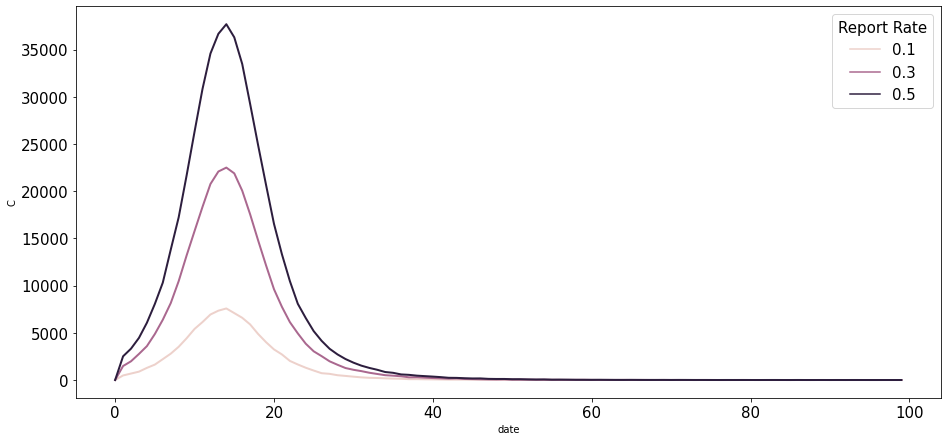

In [28]:
priors_range_dict  = {}
priors_range_dict["beta"]  = [0.2, 1]    # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3] # Recovery rate range


gamma_truth  = 1/7
beta_truth   = 3.5 * gamma_truth
report_rates = [0.1, 0.3, 0.5]

x_sol_all_df = pd.DataFrame(columns=["S", "I", "R", "C", "report_rate"]); x_sol_all_df.index.name="date"

for report_rate in report_rates:

    pop = 1e6
    num_days = 100
    x  = [pop-0.01*pop, 0.01*pop, 0, 0]


    x_sol        = np.zeros((num_days, 4))
    x_sol[0, :] = x
    for d_idx in range(1, num_days):
        x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_truth, gamma_truth, report_rate, N=pop)

    x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"
    x_sol_df["report_rate"] = report_rate
    dates        = x_sol_df.index.values
    x_sol_all_df = x_sol_all_df.append(x_sol_df)


fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))

sns.lineplot(ax=ax, data= x_sol_all_df.reset_index(), x="date", y="C", hue="report_rate", lw=2)
ax.legend(title="Report Rate", fontsize=15, title_fontsize=15)
ax.tick_params( which='both', axis='both', labelsize=15)


In [46]:
def cost_function(params, real_world_observations, num_times): #negative log likelihood
	params = np.abs(params)

	beta_truth  = params[0]
	gamma_truth = params[1]

	real_world_observations = np.array(real_world_observations)

	pop = 1e6
	num_days = 100
	x  = [pop-0.01*pop, 0.01*pop, 0, 0]


	x_sol        = np.zeros((num_days, 4))
	x_sol[0, :] = x
	for d_idx in range(1, num_days):
		x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_truth, gamma_truth, N=pop)

	# Assume observation is in the last dimension.
	model_observations = x_sol[:, -1]

	nll = poisson_loglikelihood(np.expand_dims(real_world_observations_df, 0), np.expand_dims(model_observations, 0))
	return nll


In [47]:
x_sol        = np.zeros((num_days, 4))
x_sol[0, :] = x
for d_idx in range(1, num_days):
    x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_truth, gamma_truth, N=pop)

x_sol_df                   = pd.DataFrame(x_sol, columns=["S", "I", "R", "C"]); x_sol_df.index.name="date"
real_world_observations_df = x_sol_df["C"]

In [66]:
import scipy.optimize as optimize

params = [0.4, 0.25] #make sure all the params and inition states are float

num_days = 100

#### Parameter estimation ####
optimizer = optimize.minimize(cost_function, params, args=(real_world_observations_df.values, num_days), method='Nelder-Mead')
paramests = np.abs(optimizer.x)

paramests


pop       = 1e6
num_days  = 100
num_iters = 100
x         = [pop-0.01*pop, 0.01*pop, 0, 0]

x_est_all_df = pd.DataFrame(columns=["S", "I", "R", "C", "iter_id"]); x_est_all_df.index.name="date"

x_sol           = np.zeros((4, num_days, int(num_iters)))
x_sol[ :, 0, :] = np.expand_dims(x, -1) * np.ones((1, int(num_iters)))

for idx_date, date in tqdm(enumerate(dates[1:])):
    # Integrate all particles.
    for idx_ens in range(num_iters):
        x_sol[:, idx_date+1, idx_ens] = model(x_sol[:, idx_date, idx_ens], paramests[0], paramests[1], N=1e6)

sus_df = create_df_response(x_sol[0,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
inf_df = create_df_response(x_sol[1,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
rec_df = create_df_response(x_sol[2,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)
inc_df = create_df_response(x_sol[3,:,:].T, time=len(dates), date_init ='2020-01-01',  quantiles = [50, 80, 95], use_future=False)


99it [00:00, 601.84it/s]


In [67]:
inc_df

,mean,median,std,low_50,high_50,low_80,high_80,low_95,high_95,type
date,,,,,,,,,,
2020-01-01,0.00,0.0,0.000000,0.00,0.00,0.0,0.0,0.00,0.000,estimate
2020-01-02,1532.26,1531.0,39.278755,1506.50,1556.25,1484.9,1587.0,1462.75,1612.775,estimate
2020-01-03,2069.37,2073.5,42.046308,2045.50,2093.25,2016.9,2128.2,1980.75,2141.525,estimate
2020-01-04,2787.81,2778.0,54.330395,2755.75,2815.25,2730.1,2848.1,2690.00,2916.775,estimate
2020-01-05,3742.82,3739.5,76.933971,3680.75,3795.50,3647.8,3846.9,3609.40,3899.525,estimate
...,...,...,...,...,...,...,...,...,...,...
2020-04-05,0.05,0.0,0.219043,0.00,0.00,0.0,0.0,0.00,1.000,estimate
2020-04-06,0.10,0.0,0.301511,0.00,0.00,0.0,0.1,0.00,1.000,estimate
2020-04-07,0.03,0.0,0.171447,0.00,0.00,0.0,0.0,0.00,0.525,estimate


Text(0.5, 1.0, '$\\beta$=0.500, $\\beta_{MLE}$=0.5168 |  $\\gamma$=0.143, $\\gamma_{MLE}$=0.1614 ')

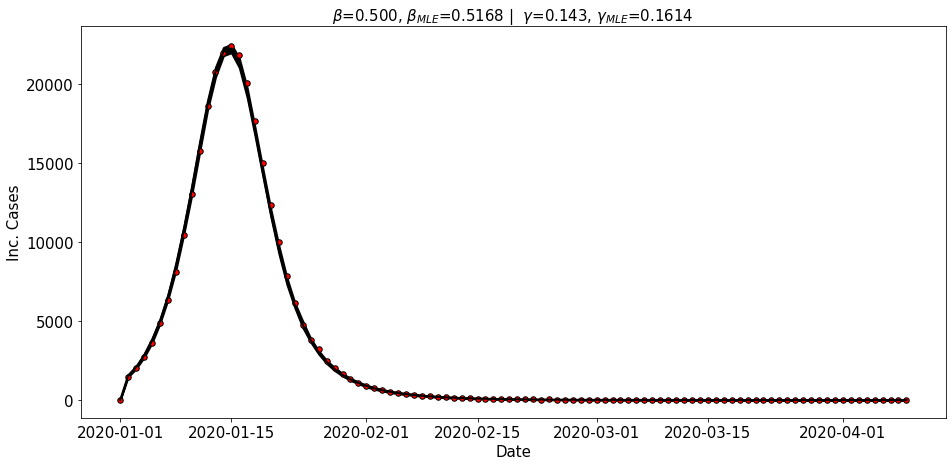

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
ax.plot(inc_df.index.values, inc_df["mean"], color='k', linewidth=2, label='Sim with estimated parameters')
ax.fill_between(inc_df.index.values, inc_df["low_95"], inc_df["high_95"], color='k', linewidth=2)


ax.scatter(inc_df.index.values, real_world_observations_df.values, edgecolor="k", facecolor="red", label="Observations", s=30)

ax.tick_params( which='both', axis='both', labelsize=15)
ax.set_ylabel("Inc. Cases", fontsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_title(r"$\beta$={:0.3f}, $\beta_{{MLE}}$={:0.4f} |  $\gamma$={:0.3f}, $\gamma_{{MLE}}$={:0.4f} ".format(beta_truth, paramests[0], gamma_truth, paramests[1]), fontsize=15)
